<a href="https://colab.research.google.com/github/sdutta42/DOP-HW-5/blob/main/DOP_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

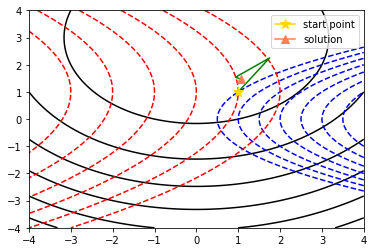

Solution for this problem is: X=(1.0604169033539965,1.4563356389457214)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

def f(x):
    f = x[0][0] ** 2 + (x[1][0] - 3) ** 2
    return f

def g(x):
    g = np.array([[x[1][0] ** 2 - 2 * x[0][0]],
                  [(x[1][0] - 1) ** 2 + 5 * x[0][0] - 15]])
    return g

def df(x):
    df = np.array([[2 * x[0][0], 2 * (x[1][0] - 3)]])
    return df

def dg(x):
    dg = np.array([[-2, 2 * x[1][0]],
                   [5, 2 * (x[1][0] - 1)]])
    return dg

def line_search(x, s, mu, w_old, k):
    t = 0.3
    a = 1

    # w = np.zeros((2, 1))
    # w[0] = max(abs(mu[0]), 0.5 * (w_last[0] + abs(mu[0])))
    # w[1] = max(abs(mu[1]), 0.5 * (w_last[1] + abs(mu[1])))

    if k == 0:
        w = abs(mu)
    else:
        w = np.zeros((2, 1))
        w[0] = max(abs(mu[0]), 0.5 * (w_old[0] + abs(mu[0])))
        w[1] = max(abs(mu[1]), 0.5 * (w_old[1] + abs(mu[1])))

    dg_da_1 = 0 if g(x)[0, :] <= 0 else np.matmul(dg(x)[0, :], s)
    dg_da_2 = 0 if g(x)[1, :] <= 0 else np.matmul(dg(x)[1, :], s)
    dF_da = np.matmul(df(x), s) + (w[0, :] * dg_da_1 + w[1, :] * dg_da_2)

    def F_a(x, w, a, s):
        g1 = max(0, g(x + a*s)[0, :])
        g2 = max(0, g(x + a*s)[1, :])
        F = f(x + a*s) + (w[0, :] * g1 + w[1, :] * g2)
        return F

    phi = lambda x, w, a, t, dF_da: F_a(x, w, 0, 0) + a * t * dF_da

    while phi(x, w, a, t, dF_da) < F_a(x, w, a, s):
        a = 0.8 * a

    return a, w

def solve_sqp(x, W):
    A0 = dg(x)
    b0 = g(x)
    mu0 = np.zeros((b0.shape[0], 1))
    mu = []
    active = []
    while True:
        if len(active) == 0:
            matrix = W
            s_mu = np.matmul(np.linalg.inv(matrix), -df(x).T)
            s = s_mu[:2, :]
            mu = []

        if len(active) != 0:
            if len(active) == 1:
                A = A0[active[0], :].reshape(1, -1)
                b = b0[active[0], :]
            if len(active) == 2:
                A = copy.deepcopy(A0)
                b = copy.deepcopy(b0)
            matrix = np.vstack((np.hstack((W, A.T)),
                                np.hstack((A, np.zeros((A.shape[0], A.shape[0]))))))
            s_mu = np.matmul(np.linalg.inv(matrix), np.vstack((-df(x).T, -b)))
            s = s_mu[:2, :]
            mu = s_mu[2:, :]
            if len(mu) == 1:
                mu0[0] = s_mu[2:3, :]
            if len(mu) == 2:
                mu0[0] = s_mu[2:3, :]
                mu0[1] = s_mu[3:, :]

        sqp_constraint = np.round((np.matmul(A0, s.reshape(-1, 1)) + b0))

        mu_check = 0

        if len(mu) == 0:
            mu_check = 1
        elif min(mu) > 0:
            mu_check = 1
        else:
            id_mu = np.argmin(np.array(mu))
            mu.remove(min(mu))
            active.pop(id_mu)

        if np.max(sqp_constraint) <= 0:
            if mu_check == 1:
                return s, mu0
        else:
            index = np.argmax(sqp_constraint)
            active.append(index)
            active = np.unique(np.array(active)).tolist()


def BFGS(W, x, dx, s, mu):
    delta_L = (df(x) + np.matmul(mu.T, dg(x))) - (df(x - dx) + np.matmul(mu.T, dg(x - dx)))
    Q = np.matmul(np.matmul(dx.T, W), dx)
    if np.matmul((dx).T, delta_L.T) >= 0.2 * np.matmul(np.matmul((dx).T, W), (dx)):
        theta = 1
    else:
        theta = 0.8 * Q / (Q - np.matmul(dx.T, delta_L.T))

    y = theta * delta_L.T + (1 - theta) * np.matmul(W, dx)
    W_new = W + np.matmul(y, y.T) / np.matmul(y.T, s) - np.matmul(np.matmul(W, s), np.matmul(s.T, W)) / np.matmul(np.matmul(s.T, W), s)

    return W_new

eps = 1e-3  # termination criterion
x0 = np.array([[1.], [1.]])
x = np.array([[1.], [1.]])
W = np.eye(x.shape[0])
mu_old = np.zeros((x.shape[0], 1))
k = 0

delta_L_norm = np.linalg.norm(df(x) + np.matmul(mu_old.T, dg(x)))
w_old = np.zeros((2, 1))
solution1 = []
solution2 = []
solution1.append(x[0][0])
solution2.append(x[1][0])

while delta_L_norm > eps:
    s, mu_new = solve_sqp(x, W)
    a, w_new = line_search(x, s, mu_old, w_old, k)

    w_old = w_new
    dx = a*s
    x += dx
    W = BFGS(W, x, dx, s, mu_new)
    k += 1
    delta_L_norm = np.linalg.norm(df(x) + np.matmul(mu_new.T, dg(x)))
    mu_old = mu_new
    solution1.append(x[0][0])
    solution2.append(x[1][0])

X1 = np.linspace(-4, 4, 81)
X2 = np.linspace(-4, 4, 81)
x1, x2 = np.meshgrid(X1, X2)

F = np.array([x1 ** 2 + (x2 - 3) ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G1 = np.array([-2 * x1 + x2 ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G2 = np.array([5 * x1 + (x2 - 1) ** 2 - 15 for x2 in X2 for x1 in X1]).reshape(x1.shape)

G1[np.where(G1 > 0)] = None
G2[np.where(G2 > 0)] = None

plt.figure(1)
plt.contour(x1, x2, F, colors='k')
plt.contour(x1, x2, G1, colors='b')
plt.contour(x1, x2, G2, colors='r')
plt.plot(solution1, solution2, c='g')
plt.plot(x0[0], x0[1], c='gold', marker='*', markersize='10', label='start point')
plt.plot(solution1[-1], solution2[-1], c='coral', marker='^', markersize='8', label='solution')
plt.legend()
plt.show()

print('Solution for this problem is: X=({},{})'.format(solution1[-1], solution2[-1]))